# Logistic Regression CPU

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import parselmouth
from tqdm import tqdm
from scipy.stats import entropy
from scipy.signal import find_peaks

In [4]:
# Now reading the CSV
df = pd.read_csv('dysnet.csv')
df.head(5)

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,ppe,jitter,shimmer,hnr_mean,speech_rate,pause_count,pause_duration_mean,rms_mean,rms_std,label
0,-311.38477,26.980896,-9.236873,-3.446952,2.797759,-13.794222,-8.201365,-2.554216,-8.087993,-5.623301,...,8.679014,0.019937,0.152964,-135.471046,6536.470588,1,0.064000,0.016381,0.015243,0
1,-320.63364,31.162016,2.956488,9.534509,12.790990,-16.227764,-0.710162,-4.909526,-18.544220,2.431236,...,8.882021,0.017777,0.126177,-129.239224,5356.881720,15,0.241067,0.022353,0.021942,0
2,-300.99728,41.158607,-7.435174,7.761700,17.381987,-22.159197,-3.731641,-0.665727,-20.164322,-0.539192,...,8.686836,0.018722,0.109250,-113.387997,4946.394558,14,0.077714,0.025352,0.021311,0
3,-420.62094,-9.740299,35.861446,-1.680403,10.240573,-1.752196,1.488229,8.667743,-3.011296,0.726974,...,8.285378,0.096660,0.193904,-141.658091,9243.238095,0,0.000000,0.003137,0.002628,0
4,-288.11353,60.211166,10.757963,16.713995,21.329540,-10.454901,2.528886,-1.848374,-13.347257,7.410037,...,7.590672,0.041010,0.126378,-77.018103,2185.376344,0,0.000000,0.026444,0.014165,0


In [8]:
# check for null values
df.isnull().sum()

mfcc_0                   0
mfcc_1                   0
mfcc_2                   0
mfcc_3                   0
mfcc_4                   0
mfcc_5                   0
mfcc_6                   0
mfcc_7                   0
mfcc_8                   0
mfcc_9                   0
mfcc_10                  0
mfcc_11                  0
mfcc_12                  0
delta_mfcc_0             0
delta_mfcc_1             0
delta_mfcc_2             0
delta_mfcc_3             0
delta_mfcc_4             0
delta_mfcc_5             0
delta_mfcc_6             0
delta_mfcc_7             0
delta_mfcc_8             0
delta_mfcc_9             0
delta_mfcc_10            0
delta_mfcc_11            0
delta_mfcc_12            0
delta2_mfcc_0            0
delta2_mfcc_1            0
delta2_mfcc_2            0
delta2_mfcc_3            0
delta2_mfcc_4            0
delta2_mfcc_5            0
delta2_mfcc_6            0
delta2_mfcc_7            0
delta2_mfcc_8            0
delta2_mfcc_9            0
delta2_mfcc_10           0
d

In [9]:
# drop all the rows with missing values
df.dropna(inplace=True)

In [18]:
df.to_csv('dysnet.csv', index=False)

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import joblib

X = df.drop('label', axis=1)
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# Define parameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'LogReg.pkl')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


['LogReg.pkl']

In [11]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     16180
           1       0.89      0.89      0.89     15932

    accuracy                           0.89     32112
   macro avg       0.89      0.89      0.89     32112
weighted avg       0.89      0.89      0.89     32112

[[14406  1774]
 [ 1817 14115]]


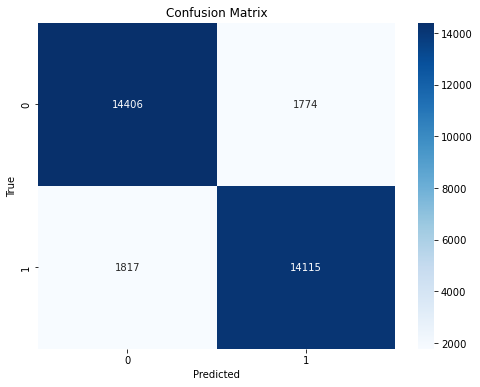

In [13]:
# plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Function to predict on new data
def predict_dysarthria(features):
    model = joblib.load('LogReg.pkl')
    prediction = model.predict(features)
    return prediction

# Example of using the model with dummy data
def create_dummy_data(n_samples=1):
    feature_means = X.mean()
    feature_stds = X.std()
    dummy_data = pd.DataFrame(
        {col: np.random.normal(mean, std, n_samples) 
         for col, mean, std in zip(X.columns, feature_means, feature_stds)}
    )
    return dummy_data

# Test prediction with dummy data
dummy_data = create_dummy_data(5)
predictions = predict_dysarthria(dummy_data)

In [16]:
dummy_data

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,pitch_std,ppe,jitter,shimmer,hnr_mean,speech_rate,pause_count,pause_duration_mean,rms_mean,rms_std
0,-314.752521,18.650090,9.669927,4.185794,-2.952409,7.561157,-7.567425,-1.861428,0.648758,-6.493084,...,941.789599,6.263122,0.001430,0.122212,-174.051477,363.206798,2.004276,0.523907,0.080559,0.076938
1,-303.041824,40.644554,9.754647,24.370421,10.687898,1.836331,-2.753014,3.202308,-8.272797,3.344838,...,1397.437514,7.518611,0.030414,0.180975,-132.979533,1493.397949,2.496007,-0.068858,0.039747,0.050938
2,-424.348604,21.703443,2.164711,44.515022,-10.805069,17.648122,-15.558752,-2.865695,-5.439233,2.865745,...,1088.570171,7.146722,0.033834,0.120802,-171.206610,1074.192360,0.431734,-0.079256,0.063476,0.071080
3,-410.614716,82.727455,22.129260,17.534002,3.249793,-2.998714,-5.622925,11.134554,-6.294173,-0.402800,...,1009.511406,6.559545,0.031791,0.146893,-135.934860,3157.826676,0.463267,0.502281,0.070632,0.129406
4,-376.307844,50.833015,-9.362265,14.871697,-0.101743,-18.217953,-13.607814,-0.970105,-4.340829,-3.133866,...,1016.302429,7.689924,0.042739,0.172774,-137.320483,2556.764991,0.823595,0.281123,0.033560,0.070339


In [17]:
predictions

array([0, 1, 1, 1, 1])

[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time= 1.3min
[CV] END ....classifier__C=100, classifier__solver=liblinear; total time=  42.4s
[CV 5/5] END classifier__C=1, classifier__solver=liblinear;, score=(train=0.887, test=0.887) total time= 1.1min
[CV] END ........classifier__C=0.1, classifier__solver=lbfgs; total time= 1.3min
[CV 3/5] END classifier__C=0.01, classifier__solver=liblinear;, score=(train=0.886, test=0.889) total time= 1.1min
[CV] END .......classifier__C=0.01, classifier__solver=lbfgs; total time= 1.4min
[CV 2/5] END classifier__C=0.01, classifier__solver=liblinear;, score=(train=0.886, test=0.886) total time= 1.1min
[CV] END ......classifier__C=1, classifier__solver=liblinear; total time= 1.4min
[CV 5/5] END classifier__C=0.01, classifier__solver=lbfgs;, score=(train=0.886, test=0.886) total time= 1.2min
[CV] END .......classifier__C=0.01, classifier__solver=lbfgs; total time= 1.4min
[CV 1/5] END classifier__C=0.01, classifier__solver=lbfgs;, s